# How consistently are areas ranked?

For each month, compute the ranking of each area in terms of ASB incidents (with smoothing) and measure temporal consistency (somehow)


In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
from collections import defaultdict
from itertools import pairwise

import matplotlib.pyplot as plt
import pandas as pd

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    Force,
    calc_gini,
    cosine_similarity,
    extract_crime_data,
    lorenz_curve,
    rank_biased_overlap,
    spearman_rank_correlation,
    spearman_rank_correlation_matrix,
    tokenize_force_name,
)

## Set parameters and fetch crime data

Spatial unit comparison (census geographies control for resident population and can vary widely in area)

Unit | Size/resolution | Mean area (km²)*
-----|-----------------|----------
MSOA |                 | 6.7
H3   | 7               | 4.6
LSOA |                 | 1.4
GRID | 1000m           | 1.0
H3   | 8               | 0.65
OA   |                 | 0.28
GRID | 500m            | 0.25
HEX  | 200m            | 0.14
GRID | 200m            | 0.04
H3   | 9               | 0.093

&ast; over West Yorkshire force area

In [38]:
FORCE: Force = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
OBSERVATION_WINDOW = 3  # months
AREA: SpatialUnit = "HEX"
AREA_PARAMETERS = defaultdict(
    dict,
    {"LSOA": {"resolution": "FE"}, "GRID": {"size": 500.0}, "H3": {"resolution": 8}, "HEX": {"size": 200.0}},
)
SAMPLE_FRACTION = 0.5

In [39]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(tokenize_force_name(FORCE), filters={"Crime type": CATEGORY})
# remove any points outside boundary
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
timespan = len(raw_crime_data.Month.unique()) / 12
raw_crime_data

Month            Reported by           Falls within  \
Crime ID                                                          
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
...           ...                    ...                    ...   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type                       geometry  
Crime ID                                                        
NaN       Anti-social behaviour  POINT (411354.013 447133.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour   POINT (411758.03 447302.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour  POINT (412391.978 447481.039)  
...                         ...                            ...  
NaN       Anti-social behaviour  POINT (446750.007 410878.044)  
NaN       Anti-social behaviour  POINT (446414.024 410431.008)  
NaN       Anti-social behaviour  POINT (446666.975 410800.005)  
NaN       Anti-social behaviour   POINT (444840.023 410291.97)  
NaN       Anti-social behaviour  POINT (444982.991 411990.995)  

[81698 rows x 8 columns]

## Get spatial data

Assign crimes to spatial units requested for later aggregation

In [44]:
crime_data, spatial_units = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])
crime_data

spatial_unit     BNG_E          BNG_N        LAT      LONG    Month  \
Crime ID                                                                        
NaN              21444  411500.0  447060.115916  53.919557 -1.826389  2022-05   
NaN               5786  411800.0  447579.731158  53.924221 -1.821801  2022-05   
NaN               5785  411800.0  447233.320997  53.921107 -1.821815  2022-05   
NaN               5786  411800.0  447579.731158  53.924221 -1.821801  2022-05   
NaN               5931  412400.0  447579.731158  53.924207 -1.812665  2022-05   
...                ...       ...            ...        ...       ...      ...   
NaN              14090  446600.0  410860.254038  53.592256 -1.297438  2025-04   
NaN              29748  446300.0  410340.638796  53.587613 -1.302047  2025-04   
NaN              14090  446600.0  410860.254038  53.592256 -1.297438  2025-04   
NaN              13653  444800.0  410167.433715  53.586186 -1.324729  2025-04   
NaN              29463  445100.0  412072.689603  53.603284 -1.319923  2025-04   

                    Reported by           Falls within  \
Crime ID                                                 
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
...                         ...                    ...   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type                       geometry  
Crime ID                                                        
NaN       Anti-social behaviour  POINT (411354.013 447133.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour   POINT (411758.03 447302.948)  
NaN       Anti-social behaviour  POINT (411854.969 447613.948)  
NaN       Anti-social behaviour  POINT (412391.978 447481.039)  
...                         ...                            ...  
NaN       Anti-social behaviour  POINT (446750.007 410878.044)  
NaN       Anti-social behaviour  POINT (446414.024 410431.008)  
NaN       Anti-social behaviour  POINT (446666.975 410800.005)  
NaN       Anti-social behaviour   POINT (444840.023 410291.97)  
NaN       Anti-social behaviour  POINT (444982.991 411990.995)  

[81698 rows x 13 columns]

In [45]:
# optionally explore discrepancies between reported point and reported LSOA
if AREA == "LSOA":
    mismatches = crime_data[crime_data["spatial_unit"] != crime_data["LSOA code"]][
        ["spatial_unit", "LSOA21NM", "LSOA code", "LSOA name", "geometry"]
    ]  # should be true if LSOA code is set correctly
    mismatches["reported_geometry"] = mismatches["LSOA code"].map(spatial_units.geometry)
    distances = mismatches.geometry.distance(mismatches.reported_geometry)
    display(
        f"Total mismatches {len(mismatches)} of which {mismatches.reported_geometry.isna().sum()} are inactive LSOAs"
    )
    display(f"Point-reported geometry discrepancy distance mean={distances.mean():.1f}m max={distances.max():.1f}m")

## Compute counts and rates

Display rates for each area on a map (too many street segments to render)

In [46]:
# ensure we account for crime-free spatial units in the data
counts = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .sort_index()
)
# num_areas = len(crime_data.area.unique())
smoothed_counts = counts.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
smoothed_counts

Month          2022-07   2022-08   2022-09   2022-10   2022-11   2022-12  \
spatial_unit                                                               
504           0.666667  1.333333  0.666667  1.000000  0.333333  0.333333   
642           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
649           0.000000  0.333333  0.333333  0.666667  0.333333  0.333333   
650           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
788           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                ...       ...       ...       ...       ...       ...   
30800         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
30801         0.333333  0.333333  0.000000  0.000000  0.000000  0.000000   
30802         1.666667  3.000000  2.666667  1.333333  0.000000  0.000000   
30803         0.000000  0.000000  0.333333  0.333333  0.666667  0.333333   
31090         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

Month          2023-01   2023-02   2023-03   2023-04  ...   2024-07   2024-08  \
spatial_unit                                          ...                       
504           0.000000  0.333333  0.333333  0.666667  ...  1.000000  0.666667   
642           0.000000  0.000000  0.000000  0.333333  ...  0.000000  0.000000   
649           0.000000  0.000000  0.000000  0.000000  ...  0.333333  0.000000   
650           0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
788           0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
...                ...       ...       ...       ...  ...       ...       ...   
30800         0.000000  0.000000  0.000000  0.000000  ...  2.000000  2.000000   
30801         0.000000  0.000000  0.000000  0.000000  ...  1.000000  1.000000   
30802         0.000000  0.333333  0.333333  0.333333  ...  0.333333  0.000000   
30803         0.333333  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
31090         0.000000  0.000000  0.000000  0.000000  ...  0.333333  0.333333   

Month          2024-09   2024-10   2024-11   2024-12   2025-01  2025-02  \
spatial_unit                                                              
504           0.333333  0.333333  0.000000  0.000000  0.000000      0.0   
642           0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
649           0.333333  0.333333  0.333333  0.000000  0.000000      0.0   
650           0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
788           0.000000  0.000000  0.333333  0.333333  0.333333      0.0   
...                ...       ...       ...       ...       ...      ...   
30800         0.666667  0.666667  0.000000  0.333333  0.666667      1.0   
30801         0.666667  0.333333  0.333333  0.333333  0.000000      0.0   
30802         0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
30803         0.000000  0.000000  0.333333  0.333333  0.333333      0.0   
31090         0.000000  0.000000  0.000000  0.000000  0.000000      0.0   

Month          2025-03   2025-04  
spatial_unit                      
504           0.333333  0.666667  
642           0.000000  0.000000  
649           0.000000  0.000000  
650           0.000000  0.000000  
788           0.000000  0.000000  
...                ...       ...  
30800         0.666667  0.666667  
30801         0.000000  0.333333  
30802         0.000000  0.333333  
30803         0.000000  0.000000  
31090         0.000000  0.000000  

[6214 rows x 34 columns]

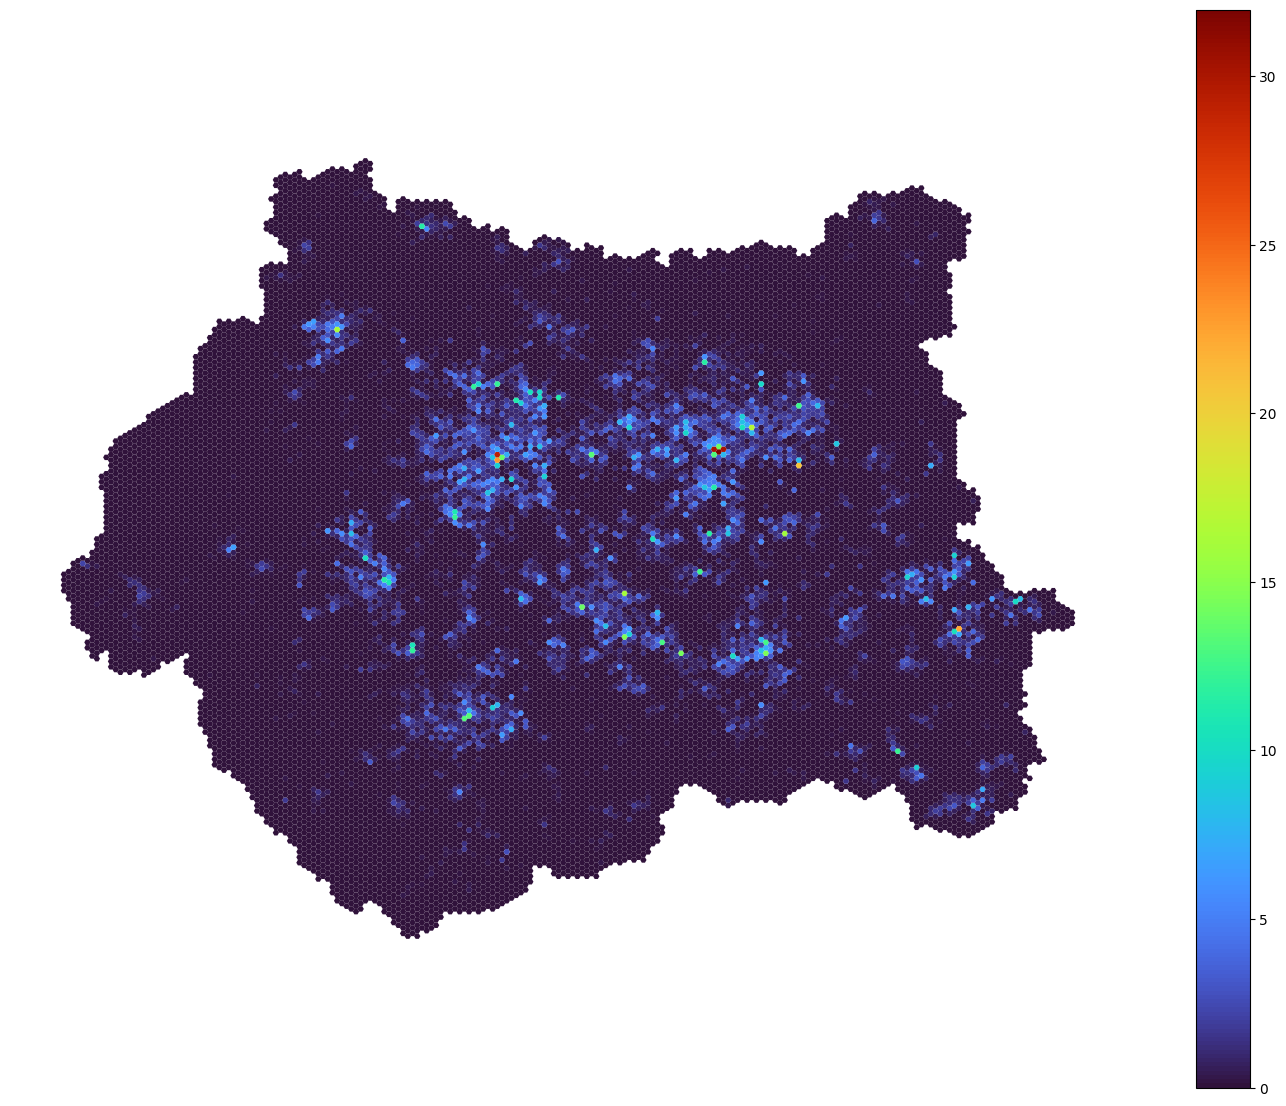

In [49]:
# compute rates
if AREA == "STREET":
    # proxy area as length * a width factor thats consistent with the force area
    width_factor = force_boundary.area.sum() / spatial_units.length.sum()
    areas = counts.index.map(spatial_units.length) * width_factor
else:
    areas = counts.index.map(spatial_units.area)

rates = counts.div(areas, axis=0) / timespan * 1_000_000  # crimes/sq.km/year
smoothed_rates = rates.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
if AREA == "STREET":
    rates.index = pd.MultiIndex.from_tuples(rates.index, names=["u", "v", "key"])

ax = (
    spatial_units.join(rates.mean(axis=1).rename("mean_rate"))
    .fillna(0)
    .plot(column="mean_rate", linewidth=0.1, legend=True, figsize=(18, 14), cmap="turbo")
)
# ax = spatial_units.plot(legend=True, figsize=(18, 14))
ax.set_axis_off()

In [50]:
if AREA == "STREET":
    map = None
else:
    map = (
        spatial_units.join(rates.sum(axis=1).rename("rate"))
        .fillna(0)
        .explore(
            "rate",
            cmap="Reds",
            tiles="CartoDB positron",
            style_kwds=dict(color="black", weight=0.5, opacity=0.2, fillOpacity=0.7),
        )
    )
# force_boundary.explore(m=map, style_kwds=dict(color="black", weight=0.5, opacity=0.2, fillOpacity=0.0))
# map

Month     2022-05   2022-06   2022-07   2022-08   2022-09   2022-10   2022-11  \
Month                                                                           
2022-05  1.000000  0.629214  0.567163  0.563355  0.613572  0.598101  0.628088   
2022-06  0.629214  1.000000  0.579819  0.578329  0.603968  0.594482  0.607110   
2022-07  0.567163  0.579819  1.000000  0.587449  0.601455  0.594113  0.592949   
2022-08  0.563355  0.578329  0.587449  1.000000  0.611866  0.607950  0.612164   
2022-09  0.613572  0.603968  0.601455  0.611866  1.000000  0.640312  0.648400   
2022-10  0.598101  0.594482  0.594113  0.607950  0.640312  1.000000  0.654614   
2022-11  0.628088  0.607110  0.592949  0.612164  0.648400  0.654614  1.000000   
2022-12  0.641605  0.624325  0.626512  0.631878  0.672219  0.670838  0.715943   
2023-01  0.621389  0.604233  0.600307  0.617022  0.649574  0.650728  0.676546   
2023-02  0.611544  0.608944  0.599191  0.601130  0.635494  0.645637  0.665620   
2023-03  0.604663  0.589308  0.579931  0.598653  0.628791  0.632809  0.653381   
2023-04  0.579318  0.572960  0.570216  0.586878  0.604768  0.607828  0.628767   
2023-05  0.568360  0.553603  0.561615  0.568225  0.598449  0.593743  0.607164   
2023-06  0.574277  0.572837  0.572438  0.591155  0.609043  0.612360  0.627954   
2023-07  0.572371  0.562378  0.561601  0.576970  0.601133  0.603077  0.632998   
2023-08  0.580399  0.578485  0.568653  0.584376  0.607655  0.609828  0.622973   
2023-09  0.588108  0.585886  0.575674  0.593917  0.606288  0.612128  0.627786   
2023-10  0.605554  0.581049  0.575229  0.591669  0.617997  0.620844  0.643867   
2023-11  0.612680  0.600164  0.587190  0.605585  0.627146  0.639706  0.664396   
2023-12  0.641160  0.620230  0.611647  0.623297  0.655719  0.661394  0.684391   
2024-01  0.618418  0.611225  0.586587  0.616941  0.645628  0.646382  0.675956   
2024-02  0.607538  0.591255  0.581902  0.590239  0.626517  0.627054  0.649876   
2024-03  0.592559  0.578751  0.569419  0.587897  0.616626  0.611060  0.634128   
2024-04  0.585046  0.566126  0.561016  0.573523  0.613003  0.608746  0.644070   
2024-05  0.565579  0.546186  0.547999  0.553732  0.584933  0.588001  0.608926   
2024-06  0.566437  0.551303  0.560078  0.558371  0.583441  0.578966  0.604692   
2024-07  0.560116  0.541863  0.552142  0.560267  0.577399  0.581669  0.606885   
2024-08  0.554330  0.549139  0.554757  0.561237  0.583142  0.589726  0.607126   
2024-09  0.585688  0.565353  0.563381  0.573951  0.611419  0.621198  0.643375   
2024-10  0.582269  0.556235  0.548070  0.555109  0.592248  0.605531  0.629476   
2024-11  0.588959  0.578902  0.575234  0.582164  0.592722  0.612616  0.641605   
2024-12  0.626253  0.600210  0.590947  0.598492  0.627672  0.635196  0.667945   
2025-01  0.605765  0.589800  0.591778  0.588909  0.619770  0.633227  0.673216   
2025-02  0.632392  0.612438  0.603952  0.600899  0.634774  0.634859  0.671694   
2025-03  0.567018  0.559020  0.560750  0.561569  0.604392  0.591072  0.616545   
2025-04  0.543615  0.533573  0.526955  0.539058  0.564814  0.571906  0.598755   

Month     2022-12   2023-01   2023-02  ...   2024-07   2024-08   2024-09  \
Month                                  ...                                 
2022-05  0.641605  0.621389  0.611544  ...  0.560116  0.554330  0.585688   
2022-06  0.624325  0.604233  0.608944  ...  0.541863  0.549139  0.565353   
2022-07  0.626512  0.600307  0.599191  ...  0.552142  0.554757  0.563381   
2022-08  0.631878  0.617022  0.601130  ...  0.560267  0.561237  0.573951   
2022-09  0.672219  0.649574  0.635494  ...  0.577399  0.583142  0.611419   
2022-10  0.670838  0.650728  0.645637  ...  0.581669  0.589726  0.621198   
2022-11  0.715943  0.676546  0.665620  ...  0.606885  0.607126  0.643375   
2022-12  1.000000  0.713745  0.697027  ...  0.632215  0.633897  0.667455   
2023-01  0.713745  1.000000  0.675518  ...  0.606278  0.604131  0.640872   
2023-02  0.697027  0.675518  1.000000  ...  0.583835  0.583417  0.630499   
2023-03  

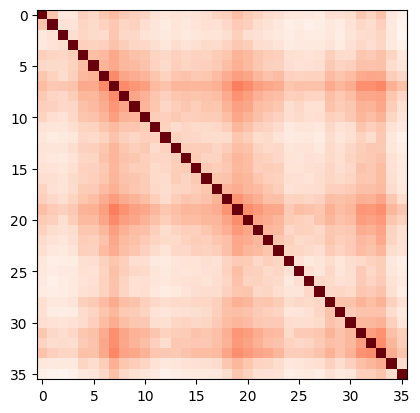

In [51]:
# rank correlation based on rates
n = len(rates.columns)
correlations = spearman_rank_correlation_matrix(rates)
cdf = pd.DataFrame(index=rates.columns, data=correlations, columns=rates.columns)
plt.imshow(cdf, cmap="Reds")
cdf

Month         2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  2023-01  \
spatial_unit                                                                  
25900            11.0     23.0     46.0     20.0      6.0      2.5      1.5   
10240            11.0      8.0      8.5      4.0      3.0      4.0      3.0   
26045             7.0     10.0      4.5     15.5      7.5      5.0      1.5   
21223           256.5    232.5    416.5    378.0     73.5     34.0     43.0   
6168             11.0     23.0     87.0    267.0    424.5    327.5    704.5   
...               ...      ...      ...      ...      ...      ...      ...   
1226            830.0    921.0   4627.5   2229.5   1947.0    848.5   1496.5   
649            4620.5   2470.5   2383.5   1287.0   1947.0   1695.0   4145.0   
30803          4620.5   4690.5   2383.5   2229.5   1064.5   1695.0   1496.5   
31090          4620.5   4690.5   4627.5   4542.0   4394.0   4263.0   4145.0   
642            4620.5   4690.5   4627.5   4542.0   4394.0   4263.0   4145.0   

Month         2023-02  2023-03  2023-04  ...  2024-07  2024-08  2024-09  \
spatial_unit                             ...                              
25900             3.0      2.0      2.0  ...      5.0      6.5      7.0   
10240             5.5      4.0      6.0  ...      2.5      4.5      2.5   
26045             1.5      1.0      1.0  ...      9.0      3.0      5.0   
21223           219.0    824.5    568.0  ...      9.0     18.5     21.5   
6168            150.0     91.5     39.0  ...    174.5   2370.0   1266.0   
...               ...      ...      ...  ...      ...      ...      ...   
1226           1495.0   4288.5   4421.0  ...   2425.0   1363.0   1266.0   
649            4161.0   4288.5   4421.0  ...   2425.0   4644.5   2251.5   
30803          4161.0   4288.5   4421.0  ...   4678.0   4644.5   4575.0   
31090          4161.0   4288.5   4421.0  ...   2425.0   2370.0   4575.0   
642            4161.0   4288.5   1952.0  ...   4678.0   4644.5   4575.0   

Month         2024-10  2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  
spatial_unit                                                                 
25900            12.0     20.0      4.0      9.0      5.0      4.5      1.0  
10240             4.0      2.0      2.0      2.0      8.0      6.5      2.0  
26045             2.0      3.0      1.0      5.5      6.5      2.5      3.0  
21223            34.5     45.5     71.5     70.0    221.0     15.0      4.0  
6168            341.0     14.0      6.0      7.5      9.0      8.5      5.0  
...               ...      ...      ...      ...      ...      ...      ...  
1226           1243.0   2073.0   1972.5   1733.0   1480.5   1675.0   4453.0  
649            2197.0   2073.0   4423.0   4309.0   4162.0   4263.5   4453.0  
30803          4529.0   2073.0   1972.5   1733.0   4162.0   4263.5   4453.0  
31090          4529.0   4470.0   4423.0   4309.0   4162.0   4263.5   4453.0  
642            4529.0   4470.0   4423.0   4309.0   4162.0   4263.5   4453.0  

[6214 rows x 34 columns]

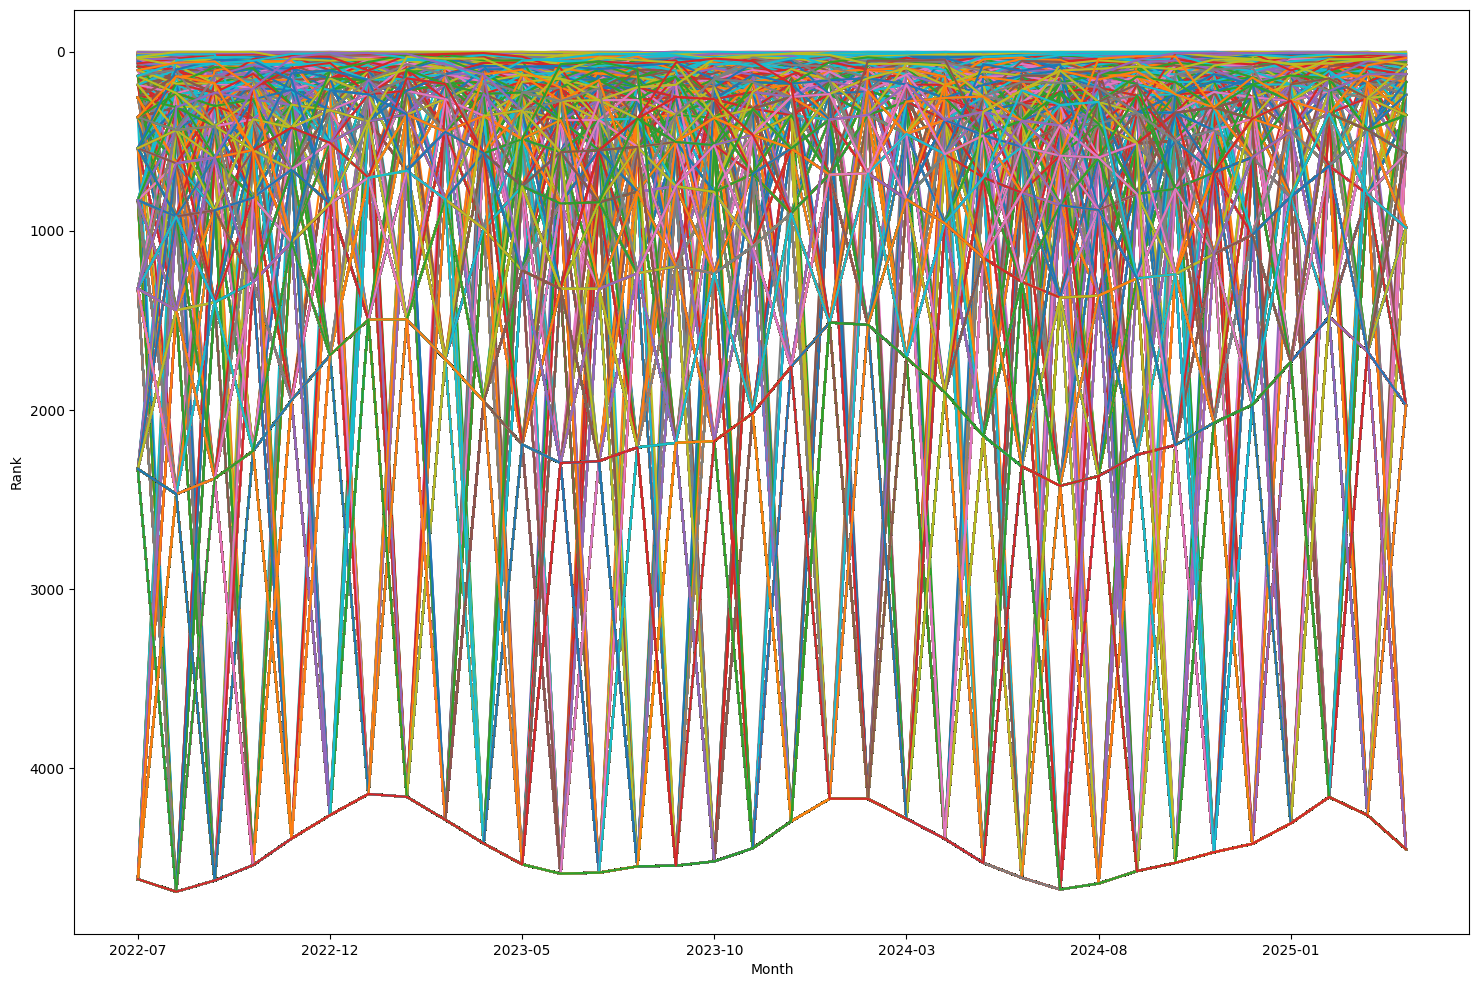

In [52]:
# ranks based on counts (default method "average" treats 2 tied at 3rd place as 3.5)
count_ranks = smoothed_counts.apply(lambda col: col.rank(ascending=False))

ax = count_ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

count_ranks.sort_values(by=count_ranks.columns[-1])

Month         2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  2023-01  \
spatial_unit                                                                  
25900            11.0     23.5     49.5     21.0      6.0      2.5      1.5   
10240            11.0      8.0      8.5      4.0      3.0      4.0      3.0   
26045             7.0      9.5      4.5     16.0      7.5      5.0      1.5   
21223           246.0    227.0    423.5    387.5     75.0     34.0     40.5   
6168             11.0     23.5     87.5    287.0    434.5    334.0    707.0   
...               ...      ...      ...      ...      ...      ...      ...   
1226            797.0    888.0   4627.5   2230.0   1947.5    851.5   1500.0   
649            4620.5   2470.5   2383.5   1287.0   1947.5   1697.5   4145.0   
30803          4620.5   4690.5   2383.5   2230.0   1064.5   1697.5   1500.0   
31090          4620.5   4690.5   4627.5   4542.0   4394.0   4263.0   4145.0   
642            4620.5   4690.5   4627.5   4542.0   4394.0   4263.0   4145.0   

Month         2023-02  2023-03  2023-04  ...  2024-07  2024-08  2024-09  \
spatial_unit                             ...                              
25900             3.0      2.0      2.0  ...      5.0      6.0      7.0   
10240             6.0      4.0      6.0  ...      2.5      5.0      3.0   
26045             1.5      1.0      1.0  ...      9.5      3.0      5.0   
21223           221.5    828.5    543.5  ...      8.0     18.5     20.5   
6168            154.5     93.0     38.5  ...    179.5   2380.0   1275.0   
...               ...      ...      ...  ...      ...      ...      ...   
1226           1498.5   4288.5   4421.0  ...   2430.5   1369.5   1275.0   
649            4161.0   4288.5   4421.0  ...   2430.5   4644.5   2262.5   
30803          4161.0   4288.5   4421.0  ...   4678.0   4644.5   4575.0   
31090          4161.0   4288.5   4421.0  ...   2430.5   2380.0   4575.0   
642            4161.0   4288.5   1957.0  ...   4678.0   4644.5   4575.0   

Month         2024-10  2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  
spatial_unit                                                                 
25900            12.5     22.0      4.0      9.0      5.0      5.0      1.0  
10240             4.0      2.0      2.0      2.0      8.0      6.0      2.0  
26045             2.0      3.0      1.0      5.5      6.0      3.0      3.0  
21223            34.5     44.0     66.5     68.5    228.5     15.0      4.0  
6168            347.5     15.0      6.0      7.0      9.0      8.0      5.0  
...               ...      ...      ...      ...      ...      ...      ...  
1226           1253.0   2085.0   1984.5   1753.5   1504.5   1700.0   4453.0  
649            2207.5   2085.0   4423.0   4309.0   4162.0   4263.5   4453.0  
30803          4529.0   2085.0   1984.5   1753.5   4162.0   4263.5   4453.0  
31090          4529.0   4470.0   4423.0   4309.0   4162.0   4263.5   4453.0  
642            4529.0   4470.0   4423.0   4309.0   4162.0   4263.5   4453.0  

[6214 rows x 34 columns]

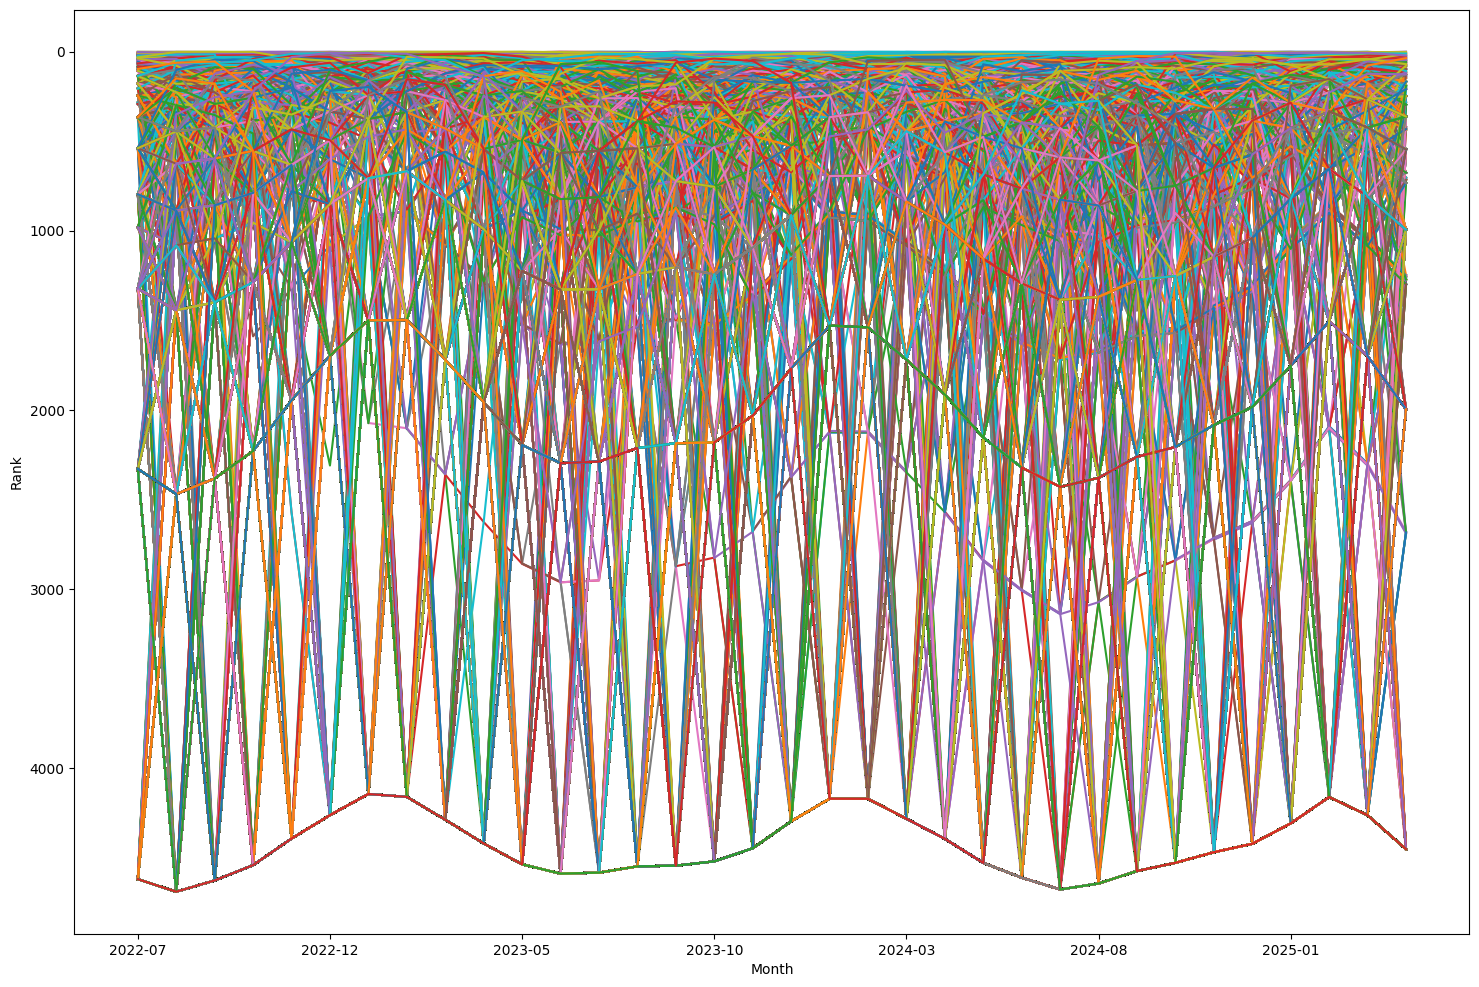

In [53]:
# ranks based on rates
rate_ranks = smoothed_rates.apply(lambda col: col.rank(ascending=False))

ax = rate_ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

rate_ranks.sort_values(by=rate_ranks.columns[-1])

In [54]:
# compute month=-on-month stats
month_on_month = pd.DataFrame(index=pd.MultiIndex.from_tuples(pairwise(count_ranks.columns)))

month_on_month["Spearman rank correlation (count)"] = month_on_month.index.map(
    lambda idx: spearman_rank_correlation(count_ranks[list(idx)])
)
month_on_month["Spearman rank correlation (rate)"] = month_on_month.index.map(
    lambda idx: spearman_rank_correlation(rate_ranks[list(idx)])
)
month_on_month["Rank-biased overlap (count)"] = month_on_month.index.map(
    lambda idx: rank_biased_overlap(count_ranks[list(idx)])
)
month_on_month["Rank-biased overlap (rate)"] = month_on_month.index.map(
    lambda idx: rank_biased_overlap(rate_ranks[list(idx)])
)
month_on_month["Cosine similarity (count)"] = month_on_month.index.map(
    lambda idx: cosine_similarity(smoothed_counts[list(idx)])
)
month_on_month["Cosine similarity (rate)"] = month_on_month.index.map(
    lambda idx: cosine_similarity(smoothed_rates[list(idx)])
)

month_on_month

Spearman rank correlation (count)  \
2022-07 2022-08                           0.834744   
2022-08 2022-09                           0.863716   
2022-09 2022-10                           0.841806   
2022-10 2022-11                           0.834662   
2022-11 2022-12                           0.867919   
2022-12 2023-01                           0.810763   
2023-01 2023-02                           0.817872   
2023-02 2023-03                           0.841237   
2023-03 2023-04                           0.820642   
2023-04 2023-05                           0.832625   
2023-05 2023-06                           0.861646   
2023-06 2023-07                           0.853902   
2023-07 2023-08                           0.836241   
2023-08 2023-09                           0.838676   
2023-09 2023-10                           0.835808   
2023-10 2023-11                           0.850473   
2023-11 2023-12                           0.856036   
2023-12 2024-01                           0.819337   
2024-01 2024-02                           0.805701   
2024-02 2024-03                           0.835503   
2024-03 2024-04                           0.838867   
2024-04 2024-05                           0.815372   
2024-05 2024-06                           0.836298   
2024-06 2024-07                           0.846452   
2024-07 2024-08                           0.833199   
2024-08 2024-09                           0.846782   
2024-09 2024-10                           0.827523   
2024-10 2024-11                           0.828273   
2024-11 2024-12                           0.870733   
2024-12 2025-01                           0.822815   
2025-01 2025-02                           0.818003   
2025-02 2025-03                           0.796438   
2025-03 2025-04                           0.809468   

                 Spearman rank correlation (rate)  \
2022-07 2022-08                          0.834428   
2022-08 2022-09                          0.863598   
2022-09 2022-10                          0.841650   
2022-10 2022-11                          0.834350   
2022-11 2022-12                          0.868006   
2022-12 2023-01                          0.810637   
2023-01 2023-02                          0.817238   
2023-02 2023-03                          0.841178   
2023-03 2023-04                          0.820979   
2023-04 2023-05                          0.832345   
2023-05 2023-06                          0.861582   
2023-06 2023-07                          0.853675   
2023-07 2023-08                          0.836073   
2023-08 2023-09                          0.838358   
2023-09 2023-10                          0.835582   
2023-10 2023-11                          0.850682   
2023-11 2023-12                          0.855687   
2023-12 2024-01                          0.820360   
2024-01 2024-02                          0.805940   
2024-02 2024-03                          0.835579   
2024-03 2024-04                          0.838504   
2024-04 2024-05                          0.814856   
2024-05 2024-06                          0.836538   
2024-06 2024-07                          0.846475   
2024-07 2024-08                          0.833476   
2024-08 2024-09                          0.847454   
2024-09 2024-10                          0.827775   
2024-10 2024-11                          0.827841   
2024-11 2024-12                          0.871304   
2024-12 2025-01                          0.823689   
2025-01 2025-02                          0.817817   
2025-02 2025-03                          0.797571   
2025-03 2025-04                          0.810488   

                 Rank-biased overlap (count)  Rank-biased overlap (rate)  \
2022-07 2022-08                     0.470814                    0.450661   
2022-08 2022-09                     0.453445                    0.454374   
2022-09 2022-10                     0.363745                    0.417359   
2022-10 2022-11                     0.511511                    0.508688 

In [55]:
def calc_stats(counts: pd.Series):
    total_areas = len(counts)
    full_lorenz = lorenz_curve(counts)
    gini, lorenz = calc_gini(counts)  # .sort_values().cumsum() / counts.sum()
    return pd.Series(
        data={
            "prop_zero": (counts == 0).mean(),
            "prop_threshold": (full_lorenz >= SAMPLE_FRACTION).sum() / total_areas,
            "gini": gini,
            "lorenz": lorenz.to_numpy(),
            # TODO list top x areas?
        },
        name=counts.name,
    )


stats = pd.concat([calc_stats(series) for _, series in smoothed_counts.items()], axis=1).T
stats

prop_zero prop_threshold      gini  \
2022-07  0.513035       0.091728  0.727594   
2022-08  0.490505       0.092855  0.720604   
2022-09  0.510782       0.088027  0.733559   
2022-10  0.538301       0.084004  0.746655   
2022-11  0.585935       0.075153  0.770057   
2022-12  0.628098       0.069199  0.787135   
2023-01  0.666077       0.065819  0.802006   
2023-02  0.660927       0.067267  0.795233   
2023-03  0.619891       0.076279  0.774062   
2023-04  0.577245       0.079659  0.757655   
2023-05  0.539749       0.084326  0.744736   
2023-06  0.523013       0.085452  0.741297   
2023-07  0.524783       0.084165   0.74312   
2023-08  0.536048       0.081751  0.747924   
2023-09  0.537335       0.082395  0.746361   
2023-10   0.54506       0.081912  0.750796   
2023-11  0.568555       0.076118  0.763584   
2023-12  0.616994       0.068233  0.785265   
2024-01  0.657547       0.066624  0.795963   
2024-02  0.657387        0.06775  0.793188   
2024-03  0.621661       0.074026   0.77768   
2024-04  0.585613       0.074187  0.766105   
2024-05  0.542324       0.079659  0.749243   
2024-06  0.515771        0.08513    0.7354   
2024-07  0.494528       0.088671  0.725691   
2024-08  0.505311       0.090763    0.7287   
2024-09  0.527679        0.08851  0.736342   
2024-10  0.542485       0.086418  0.743018   
2024-11  0.561474       0.079337   0.75532   
2024-12  0.576601       0.076279  0.762494   
2025-01  0.613293       0.070325  0.778994   
2025-02  0.660605       0.060187  0.803957   
2025-03  0.627937        0.06936  0.786027   
2025-04  0.566946       0.080463  0.752969   

                                                    lorenz  
2022-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

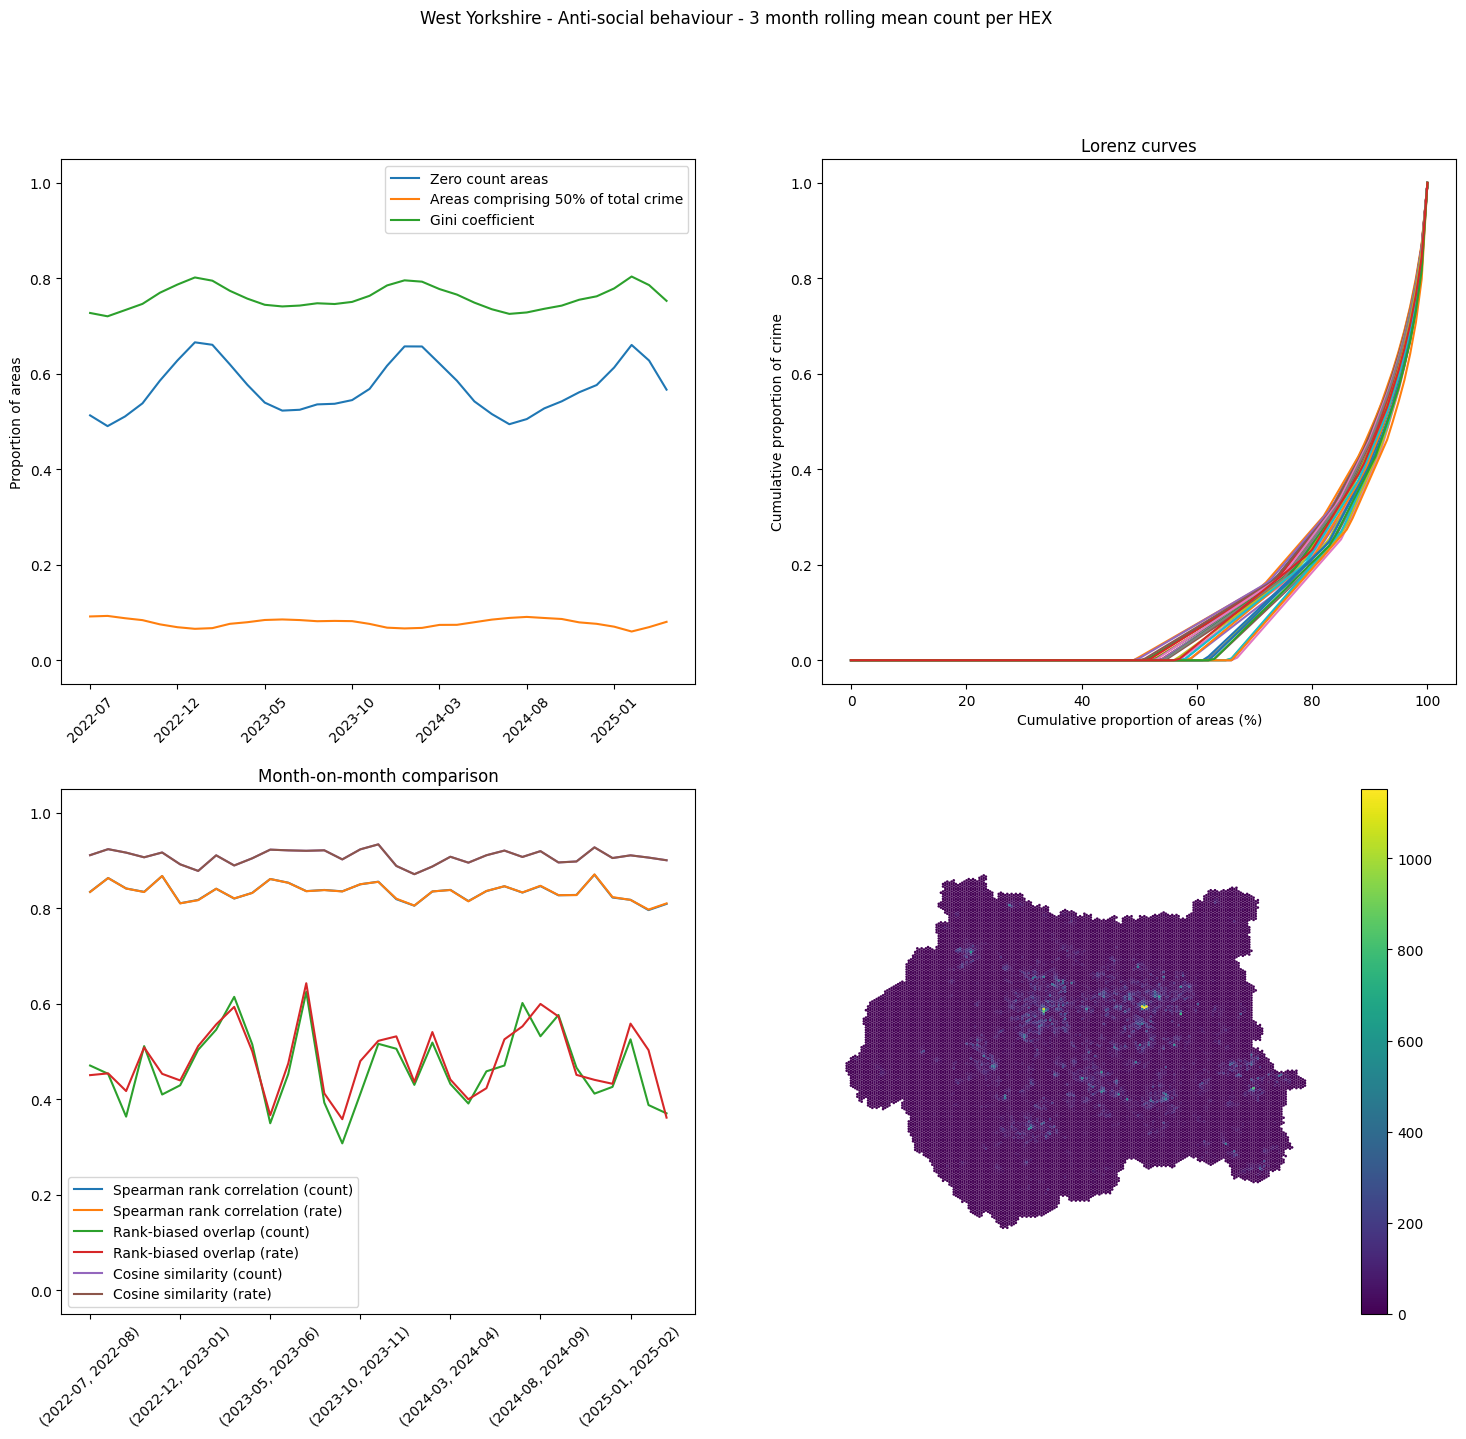

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle(f"{FORCE} - {CATEGORY} - {OBSERVATION_WINDOW} month rolling mean count per {AREA}")
# plt.tight_layout()
stats.prop_zero.plot(ax=axs[0, 0], label="Zero count areas")
stats.prop_threshold.plot(ax=axs[0, 0], label=f"Areas comprising {SAMPLE_FRACTION:.0%} of total crime")
stats.gini.plot(ax=axs[0, 0], label="Gini coefficient")
axs[0, 0].tick_params(axis="x", rotation=45)
axs[0, 0].set_ylabel("Proportion of areas")
axs[0, 0].set_ylim((-0.05, 1.05))
axs[0, 0].legend()

for name, row in stats.iterrows():
    axs[0, 1].plot(range(101), row["lorenz"], label=f"{name}")
axs[0, 1].set_xlabel("Cumulative proportion of areas (%)")
axs[0, 1].set_ylabel("Cumulative proportion of crime")
axs[0, 1].set_title("Lorenz curves")

month_on_month.plot(ax=axs[1, 0])
axs[1, 0].set_title("Month-on-month comparison")
axs[1, 0].tick_params(axis="x", rotation=45)
axs[1, 0].set_ylim((-0.05, 1.05))

if AREA != "STREET":
    spatial_units.join(rates.sum(axis=1).rename("density")).fillna(0).plot(
        ax=axs[1, 1], column="density", alpha=1, legend=True
    )
axs[1, 1].set_axis_off()